# Step 1 Data Acquisition and Visualization

In [19]:
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

In [20]:
import numpy as np
import gzip
import struct

def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)


train_labels = read_idx(r"train-labels-idx1-ubyte.gz")
train_images = read_idx(r"train-images-idx3-ubyte.gz")
test_labels = read_idx(r"t10k-labels-idx1-ubyte.gz")
test_images = read_idx(r"t10k-images-idx3-ubyte.gz")


print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)

Train Images Shape: (60000, 28, 28)
Train Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28)
Test Labels Shape: (10000,)


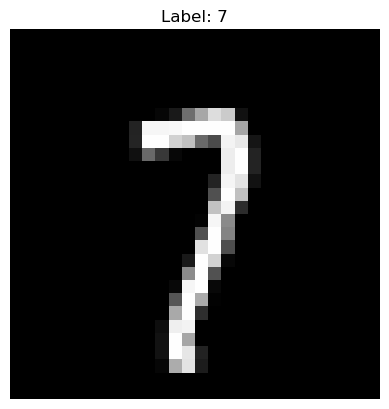

In [21]:
import matplotlib.pyplot as plt

plt.imshow(train_images[634], cmap='gray')
plt.title(f"Label: {train_labels[634]}")
plt.axis('off')
plt.show()

# Step 2 Data Preprocessing

In [22]:
#(a) Normalize pixel values to be between 0 and 1

#flattening the the train images

x_train_images = train_images.reshape(60000, 784) 
x_test_images = test_images.reshape(10000, 784)   

x_train_images = x_train_images.astype('float32')   
x_test_images = x_test_images.astype('float32')

x_train_images /= 255                        
x_test_images /= 255

x_train_images = x_train_images.T

x_train_images.shape

(784, 60000)

# Step 3 Network Initialization

In [23]:
def sigmoid(x):
    #Sigmoid activation function.
    return 1/(np.exp(-x)+1)

def d_dx_sigmoid(x):
    #Derivative of the sigmoid activation function.
    return (np.exp(-x))/((np.exp(-x)+1)**2)

def softmax(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)

def d_dx_softmax(x):
    #Softmax activation function for an array.
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)*(1-exp_element/np.sum(exp_element,axis=0))

In [24]:
# (b) Convert labels to numerical values using one-hot encoding with NumPy eye function
def one_hot_encoding(labels, num=10):
        output = np.zeros((labels.shape[0], num))
        for i, y in enumerate(labels):
            output[i][y] = 1
        output = output.T
        return output

In [25]:
# Implements a 3-layer neural network feedforward pass
def feed_forward(x, w1, w2, w3, b1, b2, b3):
    
    # Calculate the linear combination for the first layer
    z1 = np.dot(w1, x.T) + b1
    
    # Apply sigmoid activation function
    a1 = sigmoid(z1) 

    # Calculate linear combination for the second layer  
    z2 = np.dot(w2,a1) + b2
    
    # Apply sigmoid activation function
    a2 = sigmoid(z2)

    # Calculate linear combination for the third layer
    z3 = np.dot(w3,a2) + b3
    
    # Apply sigmoid activation function 
    a3 = softmax(z3)

    # Return the intermediate variables for analysis
    return z1,a1,z2,a2,z3,a3

# Step 5 Back Propagation

In [26]:
def categorical_crossentropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    y_pred_clipped = np.clip(y_pred, 1e-12, 1 - 1e-12)
    return -np.sum(y_true * np.log(y_pred_clipped)) / n_samples

In [27]:
# Implements backpropagation to calculate gradients
def back_propagation(z1,a1,z2,a2,a3,w2,w3,x,y):

  # Number of examples
  m = y.size 
  
  # One-hot encode the target labels
  one_hot_y = one_hot_encoding(y)  
  
  # Calculate error for output layer
  dz3 = a3 - one_hot_y
  
  # Transpose a2 for upcoming calculations
  a2 = a2.T
  
  # Calculate gradient for w3
  dw3 = 1/m * np.dot(dz3,a2)
  
  # Calculate gradient for b3
  db3 = 1/m * np.sum(dz3)

  # Transpose w3 for upcoming calculations
  w3 = w3.T

  # Calculate error term for middle layer
  dz2 = np.dot(w3, dz3) * d_dx_sigmoid(z2)

  # Transpose a1 for upcoming calculations
  a1 = a1.T

  # Calculate gradient for w2 
  dw2 = 1/m * np.dot(dz2,a1)

  # Calculate gradient for b2
  db2 = 1/m * np.sum(dz2)

  # Transpose w2 for upcoming calculations
  w2 = w2.T

  # Calculate error term for input layer
  dz1 = np.dot(w2,dz2) * d_dx_sigmoid(z1)

  # Transpose x for upcoming calculations
  # x = x.T

  # Calculate gradient for w1
  dw1 = 1/m * np.dot(dz1,x)

  # Calculate gradient for b1
  db1 = 1/m * np.sum(dz1)
  
  # Return the gradients
  return dw1, db1, dw2, db2, dw3, db3

# Update weights and biases using gradients and learning rate
def update_values(w1,b1,w2,b2,w3,b3,dw1, db1, dw2, db2, dw3, db3, alpha):

  # Update each weight and bias
  w1 = w1 - alpha*dw1 
  b1 = b1 - alpha*db1
  w2 = w2 - alpha*dw2
  b2 = b2 - alpha*db2
  w3 = w3 - alpha*dw3
  b3 = b3 - alpha*db3

  return w1, b1, w2, b2, w3, b3

# Step 6 Model Training

In [35]:
# Implement mini-batch gradient descent
def mini_batch_gradient_descent(x_train, y_train, batch_size, epochs):

  # Initialize weights and biases randomly 
  np.random.seed(695) 
  w1 = np.random.randn(128,784)
  w2 = np.random.randn(64,128)
  w3 = np.random.randn(10,64)
  b1 = np.random.randn(128,1)
  b2 = np.random.randn(64,1)
  b3 = np.random.randn(10,1)

  # Learning rate
  alpha = 0.05
  
  # Transpose x_train for calculations
  x_train = x_train.T
  
  # Total number of examples
  m = x_train.shape[0]
  
  for epoch in range(epochs):
    
    # Iterate over batches
    for batch_start in range(0, m, batch_size):
      
      # Batch endpoints
        batch_end = batch_start + batch_size
      
      # Extract batch
        x_batch = x_train[batch_start:batch_end]
        y_batch = y_train[batch_start:batch_end]
      
      # Forward pass
        z1,a1,z2,a2,z3,a3 = feed_forward(x_batch, w1,w2,w3,b1,b2,b3)
      
      # Backprop
        dw1, db1, dw2, db2, dw3, db3 = back_propagation(z1,a1,z2,a2,a3,w2,w3,x_batch,y_batch)
      
      # Update weights and biases
        w1, b1, w2, b2, w3, b3 = update_values(w1,b1,w2,b2,w3,b3,dw1, db1, dw2, db2, dw3, db3, alpha)

      # Calculate loss
    loss = categorical_crossentropy(y_batch, a3)
    predictions = predict(a3)

        
  # Print metrics
  print("Accuracy", accuracy_score(predictions, y_batch))

  # Return updated weights and biases
  return w1, b1, w2, b2, w3, b3

# Predictions from output layer
def predict(A2):
  return np.argmax(A2, 0)

In [36]:
w1, b1, w2, b2, w3, b3 = mini_batch_gradient_descent(x_train_images,train_labels, batch_size=128, epochs=100)

Accuracy 0.9791666666666666


# Step 7 Model Evaluation

In [37]:
# Forward pass through network with test images 
# Don't need intermediate variables
_,_,_,_,_,a3 = feed_forward(x_test_images, w1,w2,w3,b1,b2,b3)

# Get predictions by taking the argmax of output layer activations
predictions = predict(a3) 

# predictions contains the predicted classes for each test image
predictions

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [38]:
# Calculate accuracy comparing true test labels vs predicted labels
accuracy_score(test_labels, predictions)

#For each example, if prediction == true label -> correct
#Accuracy = num correct / total examples
#So this gives us the overall accuracy of the trained model on the hold out test set.


0.9263

'Looking at individual misclassified examples can provide insight into why \nthe model is failing on those instances. We can see if there are any patterns \nin the types of images being misclassified.This can help identify weaknesses  \nin the model and areas where augmentation or other techniques could help improve performance.'

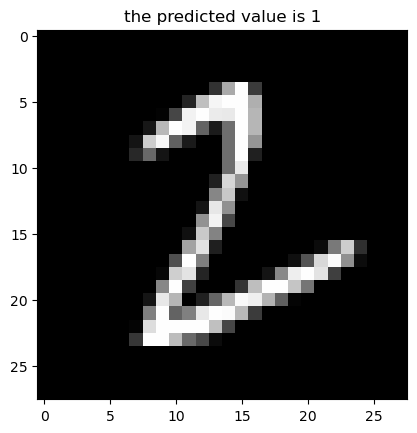

In [39]:
# Get indices where predicted label != true label
wrongimages = test_images[test_labels != predictions]

# Display one of the misclassified images 
plt.title(f'the predicted value is {predictions[2]}')
plt.imshow(wrongimages[2], cmap='gray')

'''Looking at individual misclassified examples can provide insight into why 
the model is failing on those instances. We can see if there are any patterns 
in the types of images being misclassified.This can help identify weaknesses  
in the model and areas where augmentation or other techniques could help improve performance.'''

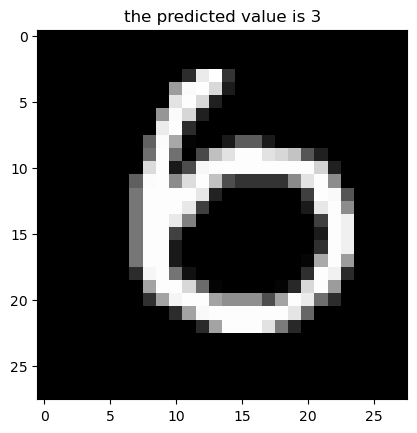

In [40]:
plt.title(f'the predicted value is {predictions[18]}')
plt.imshow(wrongimages[18], cmap='gray')

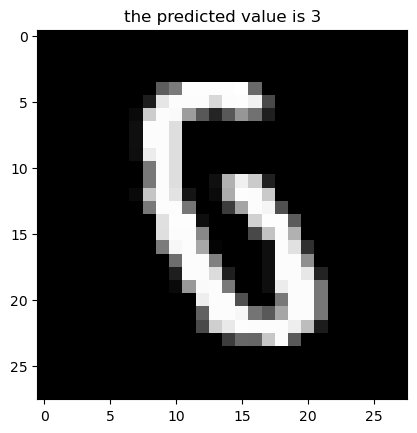

In [41]:
plt.title(f'the predicted value is {predictions[245]}')
plt.imshow(wrongimages[245], cmap='gray')